In [1]:
from SignalTemporalLogic.STLFactory import STLFactory
import matplotlib.pyplot as plt
plt.rc('font', size=12)
import copy
import pandas as pd
import seaborn as sns
import numpy as np
from collections import Counter
import warnings
import treelib
import re

# warnings.filterwarnings('ignore')
%matplotlib inline


In [2]:
#Helper Functions

def loadClientRules(popSize, dataFilename):
    clientRules = []
    clientTrees = []
    num = 1
    clientsAdded = 0
    while clientsAdded < popSize:
        fileName = dataFilename + repr(num) + "Rules.txt"
        fileFound, trees, rls = loadRuleSet(num, fileName)
        # c.logRuleSet()
        if fileFound:
            clientsAdded += 1
            clientTrees.extend(trees)
            clientRules.extend(rls)

        num += 1   
        
    #get nonduplicate list of trees
    currRls = []
    ct = []
    for t in clientTrees:
        strRl = t.toString()
        strRl = re.sub('>=', '>', strRl)
        strRl = re.sub('<=', '<', strRl)

        if strRl not in currRls:
            ct.append(t)
            currRls.append(strRl)
            
    return ct, clientRules


def loadRuleSet(num, textfile):
    ruleSet = []
    ruleTrees = []
    stlFac = STLFactory()
    try:
        file = open(textfile, "r")
        for line in file:
            if line[0] == "(" and line[-2] == ")":
                line = line[1:-2] + "\n"

            rule = stlFac.constructFormulaTree(line)
            rule.getFormulaNoParams()
                
            ruleTrees.append(rule)
            
            #fix relop for string rule
            strRl = rule.toString()
            strRl = re.sub('>=', '>', strRl)
            strRl = re.sub('<=', '<', strRl)
            ruleSet.append(strRl)

        file.close()
        return True, ruleTrees, ruleSet

    except:
        print("File not found for Client %d" % (num) )
        return False, ruleTrees, ruleSet
            


## Load Client Rules

In [3]:
#get list of client rules sorted by count
popSize = 100
dataFilename = "../Data/ICU/Best/"
# dataFilename = "../Data/Sepsis/Best/"

In [4]:
# Load Client Rule Trees and Text Rule Structures
clientTrees, clientRules = loadClientRules(popSize, dataFilename)

File not found for Client 8
File not found for Client 81


In [5]:
#Make dataframe of rules and their counts
clientDF = pd.DataFrame.from_dict(dict(Counter(clientRules)), orient='index').reset_index()
clientDF.columns=["Rule", "Rule Count"]
clientDF['Percent of Population'] = clientDF['Rule Count'] / popSize
clientDF = clientDF.sort_values("Rule Count", ascending=False)
clientDF

,Rule,Rule Count,Percent of Population
69,"((MET > 0.000) U[0,0] (death = 0.000))",230,2.30
79,"G[0,0]((n_evts < 0.000 -> LOS > 0.000))",195,1.95
62,"F[0,0]((BLOOD_UREA_NITROGEN < 0.000 & CREATINI...",77,0.77
102,"G[0,0]((hr > 0.000 & Pulse > 0.000))",46,0.46
619,"((Mort > 0.000) U[0,0] (y = 0.000))",8,0.08
...,...,...,...
1766,"F[0,0]((CREATININE < 0.000 -> y = 0.000))",1,0.01
1768,"G[0,0]((CHLORIDE > 0.000 | GLUCOSE < 0.000))",1,0.01
1769,"F[0,0]((BLOOD_UREA_NITROGEN < 0.000 -> direct ...",1,0.01
1771,"G[0,0]((s2_hr < 0.000 & s8_hr > 0.000))",1,0.01


## Load LDP Ruleset

In [6]:
resultsFilename = "../Results/ICU_Ruleset_MCTS_Baseline.csv"
ldpDF = pd.read_csv(resultsFilename, index_col=0)

ldpTrees = []
ldpRules = []

stlFac = STLFactory()
for r in ldpDF['Rule']:
    rule = stlFac.constructFormulaTree(r + "\n")
    rule.getFormulaNoParams()

    ldpTrees.append(rule)
    ldpRules.append(rule.toString())


ldpDF['Rule'] = ldpRules
ldpDF

,Rule,Percent Count
0,"F[0,0](O_Flow < 0.000)",0.500000
1,"F[0,0](ICU_Pt_Days = 0.000)",0.345000
2,"F[0,0](Pulse < 0.000)",0.500000
3,"F[0,0](ALKALINE_PHOSPHATASE > 0.000)",0.500000
4,ALKALINE_PHOSPHATASE < 0.000,0.333333
...,...,...
460,"G[0,0](n_evts < 0.000)",0.490000
461,"F[0,0](edrk = 0.000)",0.345000
462,CHLORIDE > 0.000,0.333333
463,"G[0,0](y = 0.000)",0.185000


In [7]:
#Get count of the number of true structures matched in client rules

def getTemplateNodes(temp):
    nodes = []
    
    for node in temp.expand_tree(mode=treelib.Tree.DEPTH, sorting=True):
        n = re.sub('[0-9]', '', node)
        nodes.append(n)

    return nodes

def findRuleMatch(template, clientTrees):
    ldpNodes = getTemplateNodes(template)
    ldpVars = template.getAllVars()
    
    
    for c in clientTrees:
        # check if variables in rule
        clVars = c.getAllVars()
        hasVars = True
        for v in ldpVars:
            if v not in clVars:
                hasVars = False

        if hasVars:
            # check for structural match
            clientNodes = []

            for node in c.expand_tree(mode=treelib.Tree.DEPTH, sorting=True):
                n = re.sub('[0-9]', '', node)
                clientNodes.append(n)

            # print("client nodes", clientNodes)
            if nodeListMatch(ldpNodes, clientNodes):
                return True, c.toString()  # found match

    return False, None

# check for match  between two lists of template nodes + client nodes
def nodeListMatch(tempList, cList):
    #Fix relop matches
    tempList[:] = [x if x != "LT" else "LE" for x in tempList]
    tempList[:] = [x if x != "GT" else "GE" for x in tempList]
    cList[:] = [x if x != "LT" else "LE" for x in cList]
    cList[:] = [x if x != "GT" else "GE" for x in cList]

    i = 0
    while i < len(tempList):
        if tempList[i] in cList:
            idx = cList.index(tempList[i]) #get idx of element of cList
            cList = cList[idx+1:]
        else:
            return False

        i = i+1

    return True

def getCoverage(thresh, ldpDF, ldpTrees, clientDF):
    
    #Get client rules above the threshold
    df = clientDF[clientDF['Percent of Population'] >= thresh]
    clientRules = df['Rule'].tolist()
    
    #From client rules, first make client trees
    clientTrees = []
    for c in clientRules:
        c = stlFac.constructFormulaTree(c + "\n")
        clientTrees.append(c)
    
    #Calculate num true rules, num false rules and precision (true rules / total rules found)
    foundRules = 0
    nonRules = 0
    matchLst = []
    
    for l in ldpTrees:
        fnd, cRule = findRuleMatch(l, clientTrees)
        if fnd: #check structural match --> will count partial matches as a full match
            foundRules += 1
            lCount = ldpDF[ldpDF["Rule"] == l.toString()]['Percent Count'].item()
            cCount = clientDF[clientDF["Rule"] == cRule]['Percent of Population'].item()
            matchLst.append([l.toString(), cRule, lCount, cCount])
        else:
            nonRules += 1
            
    
    lst = [len(clientRules), foundRules, nonRules, foundRules / (foundRules + nonRules) ]
    covDF = pd.DataFrame([lst], columns=["Total Client Rules", "Found Rules", "Non Rules", "Precision"]) 
    
    #Make DF that compares the count percentages of the ldp and client rules that were found
    countDF = pd.DataFrame(matchLst, columns=['LDP Rule', 'Client Rule', "LDP Count", "Client Count"])
    
    return covDF, countDF

## Get Coverage of Rules Above Threshold

In [9]:
thresh = 0.01 #Percentage match count

#Get Coverage
covDF, countDF = getCoverage(thresh, ldpDF, ldpTrees, clientDF)
covDF

,Total Client Rules,Found Rules,Non Rules,Precision
0,4085,387,78,0.832258


In [10]:
countDF

,LDP Rule,Client Rule,LDP Count,Client Count
0,"F[0,0](ICU_Pt_Days = 0.000)","F[0,0]((ICU_Pt_Days > 0.000 & y = 0.000))",0.345000,0.04
1,"F[0,0](Pulse < 0.000)","F[0,0]((Pulse < 0.000 -> y > 0.000))",0.500000,0.02
2,"F[0,0](ALKALINE_PHOSPHATASE > 0.000)","F[0,0]((ALKALINE_PHOSPHATASE < 0.000 & lds > 0...",0.500000,0.01
3,ALKALINE_PHOSPHATASE < 0.000,"((ALKALINE_PHOSPHATASE < 0.000) U[0,0] (y = 0....",0.333333,0.03
4,n_edrk > 0.000,"((death > 0.000) U[0,0] (n_edrk < 0.000))",0.333333,0.07
...,...,...,...,...
382,"F[0,0](ALT_GPT < 0.000)","F[0,0]((ALT_GPT < 0.000 & y = 0.000))",0.500000,0.02
383,"G[0,0](n_evts < 0.000)","G[0,0]((n_evts < 0.000 -> LOS > 0.000))",0.490000,1.95
384,"F[0,0](edrk = 0.000)","F[0,0]((edrk > 0.000 -> y = 0.000))",0.345000,0.03
385,CHLORIDE > 0.000,"((CHLORIDE > 0.000) U[0,0] (Mort > 0.000))",0.333333,0.05


## Calculate Rules / Query
Found rules / total queries

In [ ]:
92 / 50

In [ ]:
clientDF

## Calculate Likelihood of Finding Rule given Client Percent count
graph that shows the likelihood of learning a rule vs the # of clients who actually have the rule

In [ ]:
LL = np.sum(stats.norm.logpdf(y, pred, std_dev))

In [26]:
clientDF

,Rule,Rule Count,Percent of Population
69,"((MET > 0.000) U[0,0] (death = 0.000))",230,2.30
79,"G[0,0]((n_evts < 0.000 -> LOS > 0.000))",195,1.95
62,"F[0,0]((BLOOD_UREA_NITROGEN < 0.000 & CREATINI...",77,0.77
102,"G[0,0]((hr > 0.000 & Pulse > 0.000))",46,0.46
619,"((Mort > 0.000) U[0,0] (y = 0.000))",8,0.08
...,...,...,...
1766,"F[0,0]((CREATININE < 0.000 -> y = 0.000))",1,0.01
1768,"G[0,0]((CHLORIDE > 0.000 | GLUCOSE < 0.000))",1,0.01
1769,"F[0,0]((BLOOD_UREA_NITROGEN < 0.000 -> direct ...",1,0.01
1771,"G[0,0]((s2_hr < 0.000 & s8_hr > 0.000))",1,0.01


In [ ]:
#Might need to add the rules in clientDF that arent in the countDF --> for ldp count those would have 0


In [27]:
# countDF = countDF.sort_values("Client Count", ascending=False)
cdf = clientDF['Percent of Population']
cdf[cdf>1.0]=1.0
cdf

<ipython-input-27-a7c0823d566e>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cdf[cdf>1.0]=1.0


69      1.00
79      1.00
62      0.77
102     0.46
619     0.08
        ... 
1766    0.01
1768    0.01
1769    0.01
1771    0.01
4084    0.01
Name: Percent of Population, Length: 4085, dtype: float64

In [17]:
countDF = countDF.sort_values("Client Count", ascending=False)
df = countDF['Client Count']
df[df>1.0]=1.0
df

<ipython-input-17-0c1f5b647e99>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[df>1.0]=1.0


194    1.00
238    1.00
228    1.00
207    1.00
97     1.00
       ... 
221    0.01
209    0.01
280    0.01
134    0.01
193    0.01
Name: Client Count, Length: 387, dtype: float64

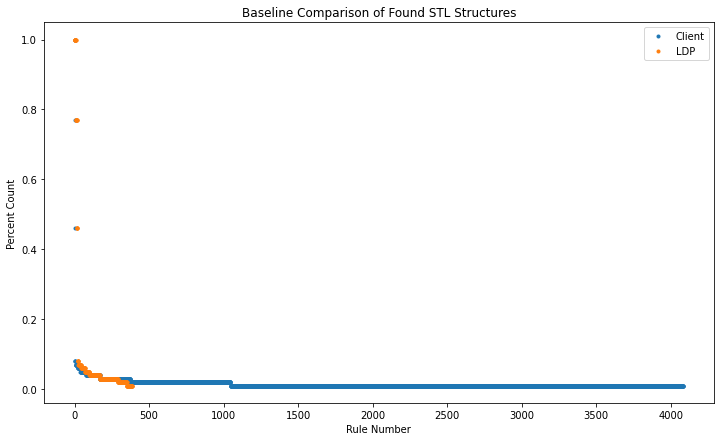

In [34]:
plt.figure(figsize=(12,7))
plt.plot(cdf.values, '.', label = 'Client')
plt.plot(df.values, '.', label = 'LDP')
plt.xlabel("Rule Number")
plt.ylabel("Percent Count")
plt.title("Baseline Comparison of Found STL Structures")
plt.legend()

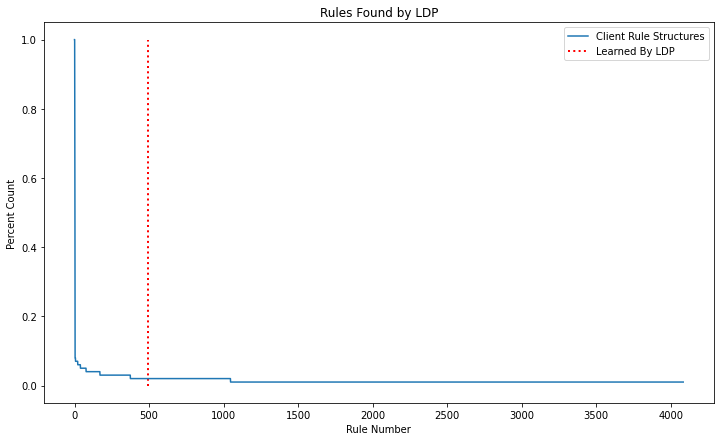

In [39]:
plt.figure(figsize=(12,7))
plt.plot(cdf.values, label = 'Client Rule Structures')
# plt.plot(df.values, '.', label = 'LDP')
plt.vlines(x=490, ymin=0, ymax=1.0, colors='red', ls=':', lw=2, label='Learned By LDP')
plt.xlabel("Rule Number")
plt.ylabel("Percent Count")
plt.title("Rules Found by LDP")
plt.legend()

Text(0.5, 1.0, 'Error Calculation of Found STL Structures')

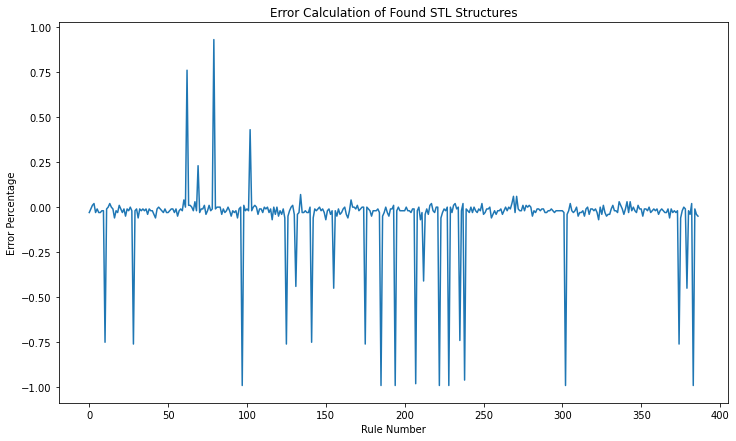

In [44]:
plt.figure(figsize=(12,7))
plt.plot(cdf-df)
plt.xlabel("Rule Number")
plt.ylabel("Error Percentage")
plt.title("Error Calculation of Found STL Structures")
# plt.legend()